In [1]:
using DifferentialEquations, Plots, StatsPlots
using CSV, DataFrames
using Turing

In [2]:
function lotka_volterra!(du, u, p, t)

  # Unpack the values so that they have clearer meaning
  x, y = u
  bx, mx, by, my = p

  # Define the ODE
  du[1] = (bx - y * mx) * x
  du[2] = (x*by - my) * y

end

lotka_volterra! (generic function with 1 method)

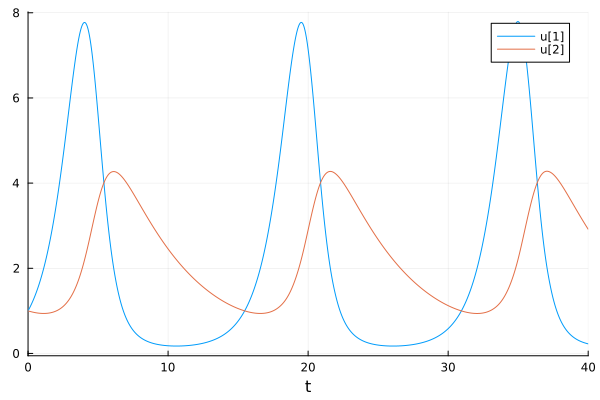

In [3]:
# Model parameters
p = [1.1, 0.5, 0.1, 0.2]

# Initial conditions
u0 = [1, 1]

# Timespan of the solution
tspan = (0.0, 40.0)

prob = ODEProblem(lotka_volterra!, u0, tspan, p)

sol = solve(prob)

plot(sol)

In [4]:
sol[1,:] # prey population

36-element Vector{Float64}:
 1.0
 1.0739931861304683
 1.369323722206105
 1.964324442660487
 3.0041406212076103
 4.879125044531147
 7.085378302560641
 7.470843718497042
 5.007071551878555
 2.1144891108104145
 ⋮
 0.46632708177361015
 1.32796229460294
 3.874256411567789
 7.794018011304492
 4.705235999315276
 1.5542186518671428
 0.619529925792528
 0.3261810342108743
 0.22514229194041674

In [5]:
sol[2,:]

36-element Vector{Float64}:
 1.0
 0.9886564988796231
 0.9584123988869967
 0.93920330441595
 0.9682996916595702
 1.133125330517017
 1.5996560174376107
 2.673935664418058
 3.7516215066327776
 4.26980268159876
 ⋮
 1.195649058798374
 0.9607683386107934
 1.0271192812414842
 2.1802774549191772
 3.844932880935744
 4.252467036180244
 3.857397474132058
 3.347962108892897
 2.9159221547861796

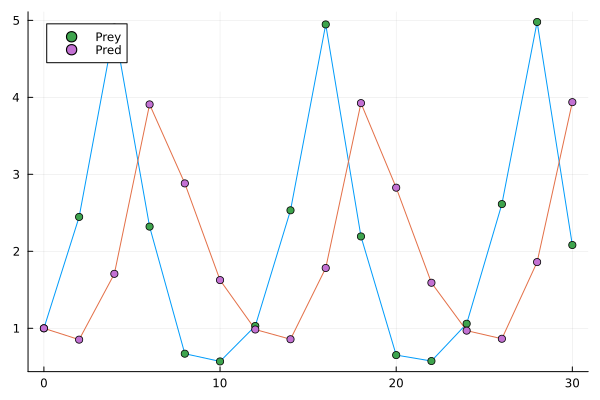

In [6]:
# load data and determine parameters

data = CSV.read("./data/lv_pop_data.csv", DataFrame)
pop_data = Array(data)'

time_plot=0:2:30;
plot(time_plot, pop_data[1, :], label=false);
plot!(time_plot, pop_data[2, :], label=false);
scatter!(time_plot, pop_data[1, :], label="Prey");
scatter!(time_plot, pop_data[2, :], label="Pred")

In [7]:
@model function fitlv(data)

    σ ~ InverseGamma(2, 3)

    bx ~ truncated(Normal(1, 0.5), 0, 2)
    mx ~ truncated(Normal(1, 0.5), 0, 2)
    by ~ truncated(Normal(1, 0.5), 0, 2)
    my ~ truncated(Normal(1, 0.5), 0, 2)

    param = [bx, mx, by, my]
    prob = ODEProblem(lotka_volterra!, u0, (0.0, 30), param)
    predicted = solve(prob, Tsit5(), saveat=2)

    for i = 1:length(predicted)
        data[1, i] ~ Normal(predicted[1,i], σ)
        data[2, i] ~ Normal(predicted[2,i], σ)
        #data[:, i] ~ MvNormal(predicted[i], σ)  # more compact using multi-variate Gaussian
    end
end

fitlv (generic function with 2 methods)

In [8]:
model = fitlv(pop_data)

posterior = sample(model, NUTS(0.6), 10000) 


Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:30:45
Sampling   1%|▍                                         |  ETA: 0:15:31
Sampling   2%|▋                                         |  ETA: 0:10:41
Sampling   2%|▉                                         |  ETA: 0:08:06
Sampling   2%|█                                         |  ETA: 0:06:33
Sampling   3%|█▎                                        |  ETA: 0:05:30
Sampling   4%|█▌                                        |  ETA: 0:04:45
Sampling   4%|█▋                                        |  ETA: 0:04:11
Sampling   4%|█▉                                        |  ETA: 0:03:44
Sampling   5%|██▏                                       |  ETA: 0:03:21
Sampling   6%|██▎                                       |  ETA: 0:03:03
Sampling   6%|

Chains MCMC chain (10000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 24.48 seconds
Compute duration  = 24.48 seconds
parameters        = σ, bx, mx, by, my
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    0.1038    0.0190    0.0004   1837.3477   1071.1814    1.0004   ⋯
          bx    0.8006    0.0127    0.0003   1946.0346   2602.0383    1.0005   ⋯
          mx    0.4003    0.0080    0.0002   2169.3607   3116.1934    1.0004   ⋯
          by    0.1999    0.0035    0.0001   2025.6520   2892.6006    1.0005   ⋯
          my    0.3998    0.0073    0.0002   2050.6

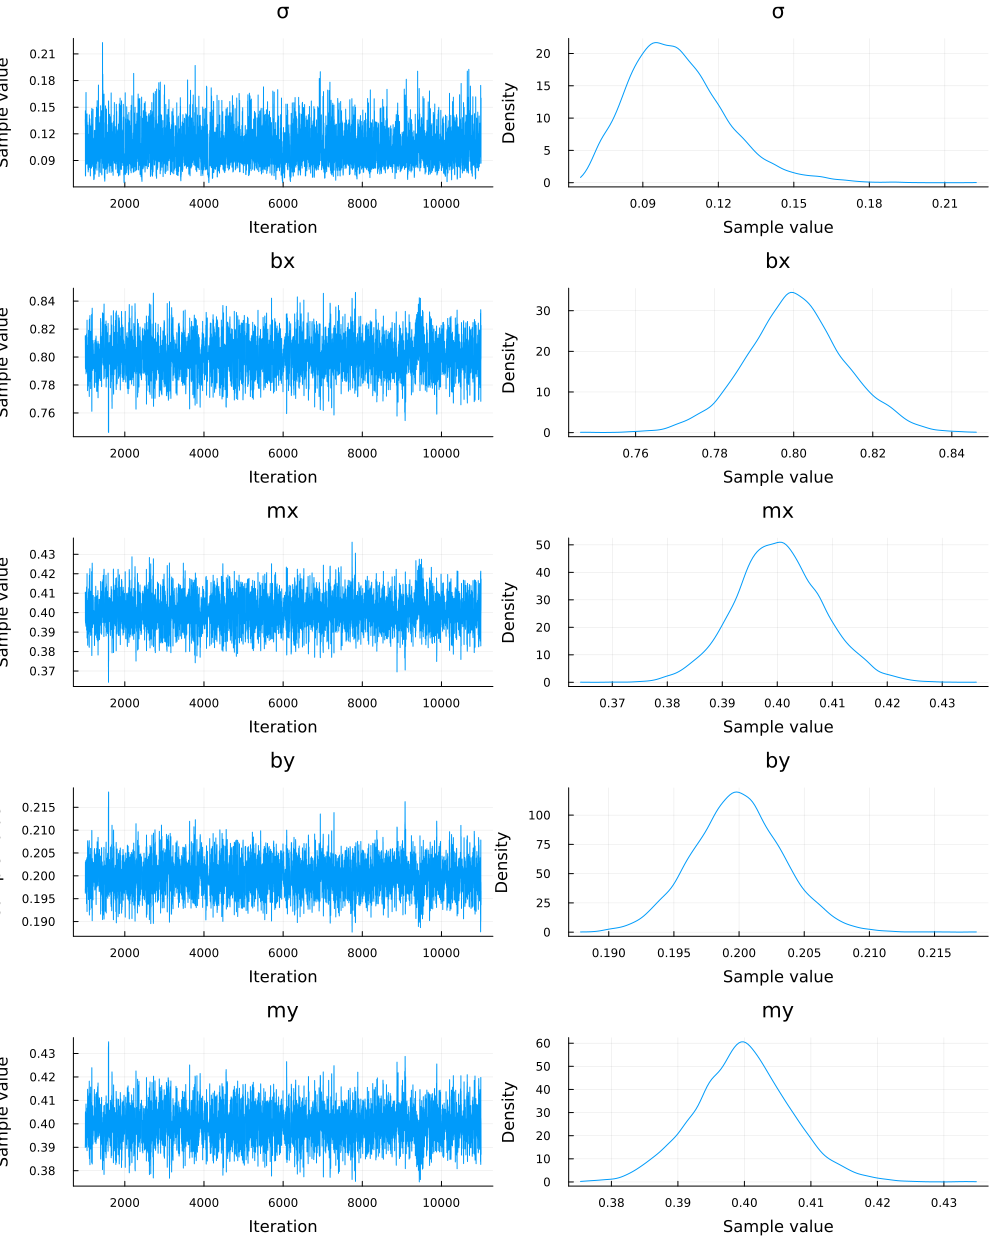

In [9]:
plot(posterior)

In [15]:
posterior_df = DataFrame(posterior)

10000×19 DataFrame
   Row │ iteration  chain  σ          bx        mx        by        my         ⋯
       │ Int64      Int64  Float64    Float64   Float64   Float64   Float64    ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │      1001      1  0.135977   0.81233   0.410428  0.196983  0.389922   ⋯
     2 │      1002      1  0.13313    0.815276  0.410269  0.197175  0.39112
     3 │      1003      1  0.128782   0.813422  0.410439  0.196201  0.39129
     4 │      1004      1  0.14598    0.805131  0.407196  0.197878  0.396554
     5 │      1005      1  0.0743592  0.793239  0.395587  0.202936  0.404462   ⋯
     6 │      1006      1  0.0730266  0.791754  0.397471  0.203047  0.405111
     7 │      1007      1  0.0730266  0.791754  0.397471  0.203047  0.405111
     8 │      1008      1  0.0736754  0.79352   0.39465   0.201217  0.403079
   ⋮   │     ⋮        ⋮        ⋮         ⋮         ⋮         ⋮         ⋮       ⋱
  9994 │     10994      1  0.11009    0.768329  0.382908  0.207832  0.419784   ⋯
  9995 │     10995      1  0.111374   0.797093  0.397611  0.198437  0.402145
  9996 │     10996      1  0.0937608  0.797926  0.399381  0.197942  0.402391
  9997 │     10997      1  0.0902648  0.802534  0.402132  0.198674  0.401311
  9998 │     10998      1  0.0868681  0.798739  0.401125  0.198291  0.400734   ⋯
  9999 │     10999      1  0.115581   0.812726  0.406574  0.193658  0.392829
 10000 │     11000      1  0.160223   0.8226    0.417269  0.196629  0.386964
                                                12 columns and 9985 rows omitted

In [16]:
birth_prey_samples = sample(posterior_df.bx, 100);
mort_prey_samples = sample(posterior_df.mx, 100);
birth_pred_samples = sample(posterior_df.by, 100);
mort_pred_samples = sample(posterior_df.my, 100);

In [17]:
solutions = []

for i in 1:length(birth_prey_samples)

    p = [birth_prey_samples[i], mort_prey_samples[i], birth_pred_samples[i], mort_pred_samples[i]];
    problem = ODEProblem(lotka_volterra!, u0, (0.0, 30.0), p);
    push!(solutions, solve(problem, saveat = 0.1));

end

In [19]:
p_mean = [mean(birth_prey_samples), mean(mort_prey_samples), mean(birth_pred_samples), mean(mort_pred_samples)];

problem_mean = ODEProblem(lotka_volterra!, u0, (0.0,30.0), p_mean);
push!(solutions, solve(problem_mean, saveat = 0.1));


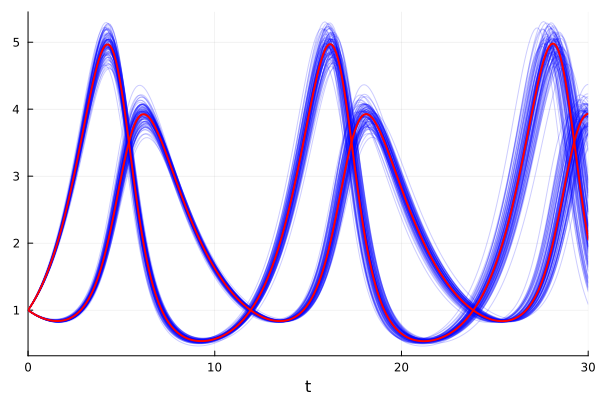

In [20]:
plot(solutions[1], alpha=0.2, color="blue");

for i in 2:(length(solutions) - 1)
    plot!(solutions[i], alpha=0.2, legend=false, color="blue");
end

plot!(solutions[end], lw = 2, color="red")


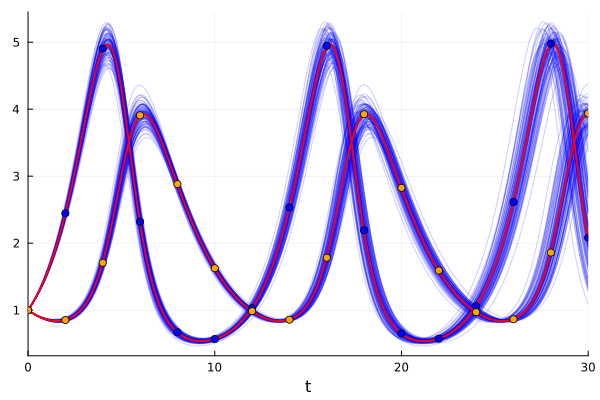

In [21]:
# Comparing inference with the data
scatter!(time_plot, pop_data[1, :], color = "blue");
scatter!(time_plot, pop_data[2, :], color = "orange")